## Stateful LSTM

The official example is [here](https://github.com/fchollet/keras/blob/master/examples/stateful_lstm.py). But I think the official way to implement stateful LSTM is not very well. In this text, I will use reshape layer before LSTM layer to implement stateful LSTM.

Notice: In Stateful LSTM, the batch_size must be fixed, which means:

    1. The first layer of model must be specifiy batch_input_shape = (batch_size, ... ,)
    3. When call moedl.fit or model.predict, the datasets must be divided by the batch size.

## 1. Preparation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense, LSTM, Reshape, Flatten

Using Theano backend.
Using gpu device 0: GeForce GTX 1080 (CNMeM is enabled with initial size: 70.0% of memory, cuDNN 5105)
/home/liuweijie/workspace/DeepLearning/keras_practice/.env/local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
# fix random seed
seed = 7
np.random.seed(seed)

In [3]:
# fix global variables
look_back = 2
batch_size = 1
epoch = 15

(50000,)
[ 100.           99.99802609   99.99210442 ...,   99.98223524   99.99210442
   99.99802609]


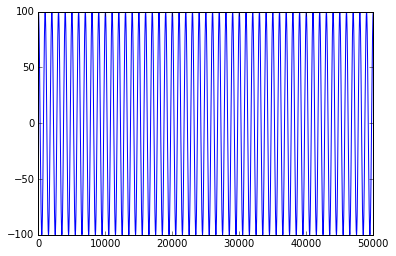

In [4]:
# generate cosine time series data
def gen_cosine_amp(amp=100, period=1000, x0=0, xn=50000, step=1, k=0.0001):
    cos = np.zeros(((xn - x0) * step, ))
    for i in range(len(cos)):
        idx = x0 + i * step
        cos[i] = amp * np.cos(2 * np.pi * idx / period)
    return cos

cosine = gen_cosine_amp()
print cosine.shape
print cosine

plt.plot(cosine)
plt.show()

In [5]:
# split time series
split_time = int(0.66*len(cosine))
cosine_train = cosine[0: split_time]
cosine_val = cosine[split_time:]

In [6]:
# create dataset
def create_dataset(time_series, look_back=1):
    dataX, dataY = [], []
    for i in range(time_series.shape[0]-look_back-1):
        a = time_series[i:(i+look_back)]
        dataX.append(a)
        dataY.append(time_series[i + look_back])
    return np.array(dataX), np.array(dataY)

X_train, Y_train = create_dataset(cosine_train, look_back)
X_val, Y_val = create_dataset(cosine_val, look_back)

print X_train.shape, Y_train.shape
print X_train[0: 5], Y_train[0: 5]

(32997, 2) (32997,)
[[ 100.           99.99802609]
 [  99.99802609   99.99210442]
 [  99.99210442   99.98223524]
 [  99.98223524   99.96841893]
 [  99.96841893   99.95065604]] [ 99.99210442  99.98223524  99.96841893  99.95065604  99.92894726]


## 2. Build a Model with Stateful LSTM

Notice: if the model contains a stateful LSTM layer (stateful=True), the first layer must specify a fixed batch size for your model, by passing batch_input_shape=(batch_size, features_number)

In [7]:
def create_stateful_lstm():
    model = Sequential()
    model.add(Reshape((1, look_back), batch_input_shape=(batch_size, look_back, )))  # ouput shape is (None, 1, look_back)
    model.add(LSTM(50, stateful=True, return_sequences=True))  # output shape is (None, 1, 50)
    model.add(Flatten())
    model.add(Dense(1, init='normal'))
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

stateful_lstm = create_stateful_lstm()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
reshape_1 (Reshape)              (1, 1, 2)             0           reshape_input_1[0][0]            
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (1, 1, 50)            10600       reshape_1[0][0]                  
____________________________________________________________________________________________________
flatten_1 (Flatten)              (1, 50)               0           lstm_1[0][0]                     
____________________________________________________________________________________________________
dense_1 (Dense)                  (1, 1)                51          flatten_1[0][0]                  
Total params: 10651
_______________________________________________________________________

## 3. Training Stateful Model

Training Stateful Model could not be train as others model, because the state should be reset at every epoch.

Notice: In a stateful network, you should only pass inputs with a number of samples that can be divided by the batch size.

In [8]:
# train
for i in range(0, epoch):
    print "Epoch: ", i, '/', epoch
    stateful_lstm.fit(X_train, Y_train, batch_size=batch_size, verbose=0, nb_epoch=1, shuffle=False)
    stateful_lstm.reset_states()

Epoch:  0 / 15
Epoch:  1 / 15
Epoch:  2 / 15
Epoch:  3 / 15
Epoch:  4 / 15
Epoch:  5 / 15
Epoch:  6 / 15
Epoch:  7 / 15
Epoch:  8 / 15
Epoch:  9 / 15
Epoch:  10 / 15
Epoch:  11 / 15
Epoch:  12 / 15
Epoch:  13 / 15
Epoch:  14 / 15


## 4. Evaluate model

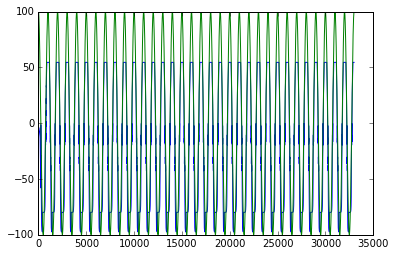

In [9]:
Y_train_pre = stateful_lstm.model.predict(X_train, batch_size=batch_size)
plt.plot(Y_train_pre)
plt.plot(Y_train)
plt.show()

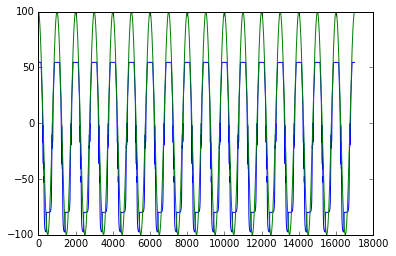

In [10]:
Y_val_pre = stateful_lstm.model.predict(X_val, batch_size=batch_size)
plt.plot(Y_val_pre)
plt.plot(Y_val)
plt.show()

OH! What a shit!